## ASR - Encoder only, CTC technique.

CTC or Connectionist Temporal Classification is a technique that is used with encoder-only transformer models for ASR.
Examples of such models are Wav2Vec2, HuBERT and M-CTC-T.


An encoder-only transformer is the simplest kind of transformer because it just uses the encoder portion of the model. The encoder reads the input sequence (the audio waveform) and maps this into a sequence of hidden-states, also known as the output embeddings.

With a CTC model, we apply an additional linear mapping on the sequence of hidden-states to get class label predictions. The class labels are the characters of the alphabet (a, b, c, …). This way we’re able to predict any word in the target language with a small classification head, as the vocabulary just needs to exist of 26 characters plus a few special tokens.

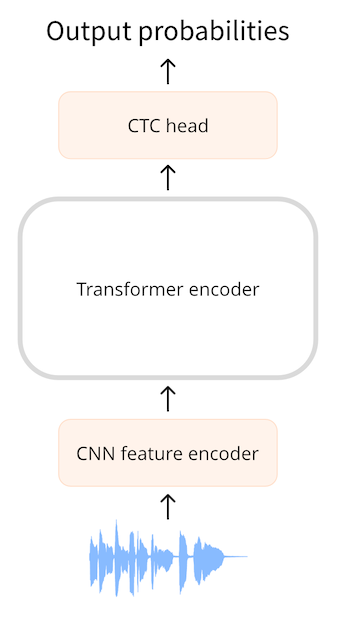

So far, this is very similar to what we do in NLP with a model such as BERT: an encoder-only transformer model maps our text tokens into a sequence of encoder hidden-states, and then we apply a linear mapping to get one class label prediction for each hidden-state.

Here’s the rub: In speech, we don’t know the alignment of the audio inputs and text outputs. We know that the order the speech is spoken in is the same as the order that the text is transcribed in (the alignment is so-called monotonic), but we don’t know how the characters in the transcription line up to the audio. This is where the CTC algorithm comes in.

In NLP models the vocabulary is usually made up of thousands of tokens that describe not just individual characters but parts of words or even complete words. For CTC, however, a small vocabulary works best and we generally try to keep it to less than 50 characters. We don't care about the casing of the letters, so only using uppercase (or only lowercase) is sufficient. Numbers are spelled out, e.g. `"20"` becomes `"twenty"`. In addition to the letters, we need at least a word separator token (space) and a padding token. Just as with an NLP model, the padding token allows us to combine multiple examples in a batch, but it's also the token the model will predict for silences. In English, it's also useful to keep the `'` character — after all, `"it's"` and `"its"` have very different meanings.

#### where’s my alignment?
Automatic speech recognition or ASR involves taking audio as input and producing text as output. We have a few choices for how to predict the text:

1. as individual characters
2. as phonemes
3. as word tokens

An ASR model is trained on a dataset consisting of (audio, text) pairs where the text is a human-made transcription of the audio file. Generally the dataset does not include any timing information that says which word or syllable occurs where in the audio file. Since we can’t rely on timing information during training, we don’t have any idea how the input and output sequences should be aligned.

Let’s suppose our input is a one-second audio file. In Wav2Vec2, the model first downsamples the audio input using the CNN feature encoder to a shorter sequence of hidden-states, where there is one hidden-state vector for every 20 milliseconds of audio. For one second of audio, we then forward a sequence of 50 hidden-states to the transformer encoder. (The audio segments extracted from the input sequence partially overlap, so even though one hidden-state vector is emitted every 20 ms, each hidden-state actually represent 25 ms of audio.)

The transformer encoder predicts one feature representation for each of these hidden-states, meaning we receive a sequence of 50 outputs from the transformer. Each of these outputs has a dimensionality of 768. The output sequence of the transformer encoder in this example therefore has shape (768, 50). As each of these predictions covers 25 ms of time, which is shorter than the duration of a phoneme, it makes sense to predict individual phonemes or characters but not entire words. CTC works best with a small vocabulary, so we’ll predict characters.

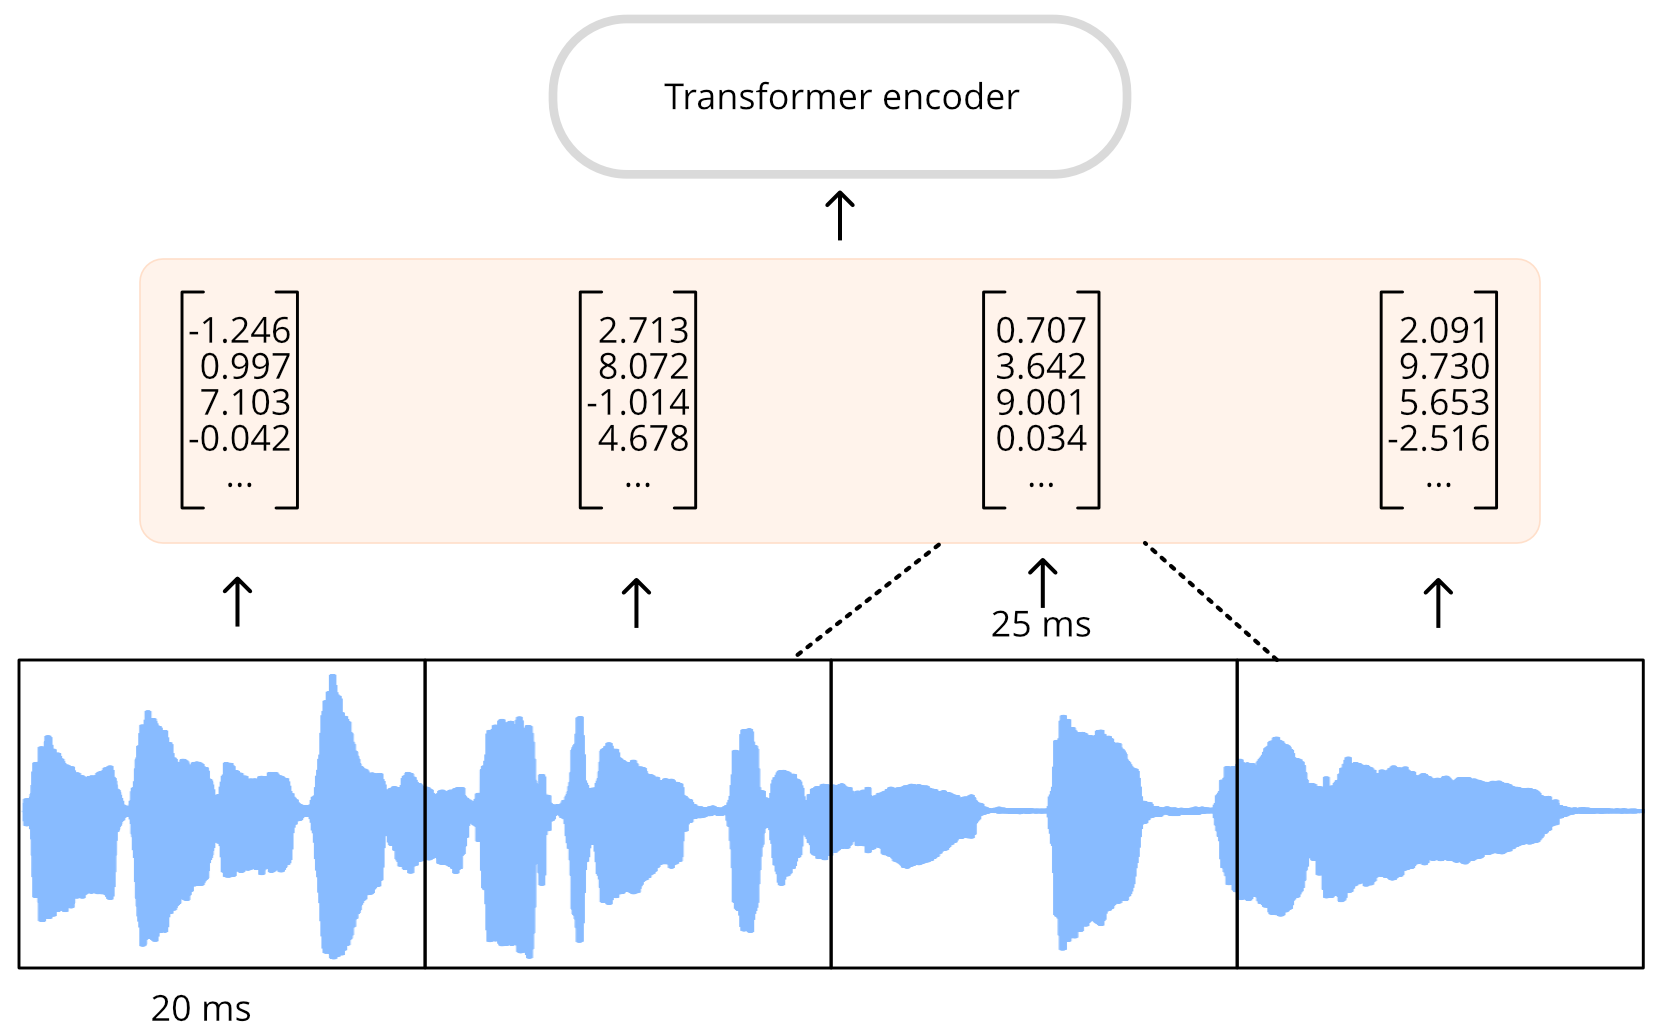

To make text predictions, we map each of the 768-dimensional encoder outputs to our character labels using a linear layer (the “CTC head”). The model then predicts a (50, 32) tensor containing the logits, where 32 is the number of tokens in the vocabulary. Since we make one prediction for each of the features in the sequence, we end up with a total of 50 character predictions for each second of audio.

However, if we simply predict one character every 20 ms, our output sequence might look something like this:

BRIIONSAWWSOMEETHINGCLOSETOPANICONHHISOPPONENT'SSFAACEWHENTHEMANNFINALLLYRREECOGGNNIIZEDHHISSERRRRORR ...

f you look closely, it somewhat resembles English but a lot of the characters have been duplicated. That’s because the model needs to output something for every 20 ms of audio in the input sequence, and if a character is spread out over a period longer than 20 ms then it will appear multiple times in the output. There’s no way to avoid this, especially since we don’t know what the timing of the transcript is during training. CTC is a way to filter out these duplicates.

(In reality, the predicted sequence also contains a lot of padding tokens for when the model isn’t quite sure what the sound represents, or for the empty space between characters. We removed these padding tokens from the example for clarity. The partial overlap between audio segments is another reason characters get duplicated in the output.)

### The CTC algorithm

The key to the CTC algorithm is using a special token, often called the blank token. This is just another token that the model will predict and it’s part of the vocabulary. In this example, the blank token is shown as _. This special token serves as a hard boundary between groups of characters.

The full output from the CTC model might be something like the following:

B_R_II_O_N_||_S_AWW_|||||_S_OMEE_TH_ING_||_C_L_O_S_E||TO|_P_A_N_I_C_||_ON||HHI_S||_OP_P_O_N_EN_T_'SS||_F_AA_C_E||_W_H_EN||THE||M_A_NN_||||_F_I_N_AL_LL_Y||||_RREE_C_O_GG_NN_II_Z_ED|||HHISS|||_ER_RRR_ORR||||

The | token is the word separator character. In the example we use | instead of a space making it easier to spot where the word breaks are, but it serves the same purpose.

The CTC blank character makes it possible to filter out the duplicate characters. For example let’s look at the last word from the predicted sequence, _ER_RRR_ORR. Without the CTC blank token, the word looked like this:

ERRRRORR

If we were to simply remove duplicate characters, this would become EROR. That’s clearly not the correct spelling. But with the CTC blank token we can remove the duplicates in each group, so that:

_ER_RRR_ORR

becomes:

_ER_R_OR

and now we remove the _ blank token to get the final word:



ERROR

If we apply this logic to the entire text, including |, and replace the surviving | characters by spaces, the final CTC-decoded output is:

BRION SAW SOMETHING CLOSE TO PANIC ON HIS OPPONENT'S FACE WHEN THE MAN FINALLY RECOGNIZED HIS ERROR

To recap, the model predicts one token (character) for every 20 ms of (partially overlapping) audio from the input waveform. This gives a lot of duplicates. Thanks to the CTC blank token, we can easily remove these duplicates without destroying the proper spelling of the words. This is a very simple and convenient way to solve the problem of aligning the output text with the input audio.

💡 In the actual Wav2Vec2 model, the CTC blank token is the same as the padding token ``. The model will predict many of these `` tokens, for example when there isn't a clear character to predict for the current 20 ms of audio. Using the same token for padding as for CTC blanking simplifies the decoding algorithm and it helps keep the vocab small.


Adding CTC to a transformer encoder model is easy: the output sequence from the encoder goes into a linear layer that projects the acoustic features to the vocabulary. The model is trained with a special CTC loss.

One downside of CTC is that it may output words that sound correct, but are not spelled correctly. After all, the CTC head only considers individual characters, not complete words. One way to improve the quality of the audio transcriptions is to use an external language model. This language model essentially acts as a spellchecker on top of the CTC output.

#### What’s the difference between Wav2Vec2, HuBERT, M-CTC-T, …?

All transformer-based CTC models have a very similar architecture: they use the transformer encoder (but not the decoder) with a CTC head on top. Architecture-wise they are more alike than different.

One difference between Wav2Vec2 and M-CTC-T is that the former works on raw audio waveforms while the latter uses mel spectrograms as input. The models also have been trained for different purposes. M-CTC-T, for example, is trained for multilingual speech recognition, and therefore has a relatively large CTC head that includes Chinese characters in addition to other alphabets.

Wav2Vec2 & HuBERT use the exact same architecture but are trained in very different ways. Wav2Vec2 is pre-trained like BERT’s masked language modeling, by predicting speech units for masked parts of the audio. HuBERT takes the BERT inspiration a step further and learns to predict “discrete speech units”, which are analogous to tokens in a text sentence, so that speech can be treated using established NLP techniques.

To clarify, the models highlighted here aren’t the only transformer-based CTC models. There are many others, but now you know they all work in a similar way.